In [1]:
import glob
import os
import sys

sys.path.append('RAFT/core')
sys.path.append('RAFT')
sys.path.append('pyflow')

from raft import RAFT
from utils.utils import InputPadder

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2

import kornia
from kornia.utils import create_meshgrid

from argparse import Namespace

from tqdm import tqdm

import pyflow

DEVICE = 'cuda'

In [2]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

def show(img, size=(16, 9)):   
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')

In [3]:
args = Namespace(
    small=True, 
    alternate_corr=False, 
    model='RAFT/models/raft-small.pth',
    path='RAFT/demo-frames/',
    mixed_precision=False
)

In [4]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()

pass

In [84]:
with torch.no_grad():
    images = glob.glob(os.path.join(args.path, '*.png')) + \
             glob.glob(os.path.join(args.path, '*.jpg'))

    images = sorted(images)
    print(len(images))
    for imfile1, imfile2 in zip(images[:-1], images[1:]):
        image1 = load_image(imfile1)
        image2 = load_image(imfile2)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        
        print(flow_up.shape)
        
        break
        # viz(image1, flow_up)

10
torch.Size([1, 2, 440, 1024])


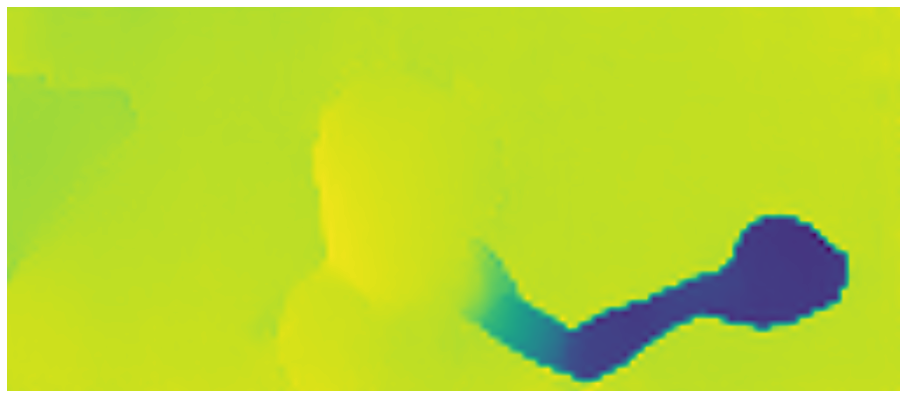

In [85]:
test = flow_up.squeeze(0).cpu().numpy()
show(test[1])

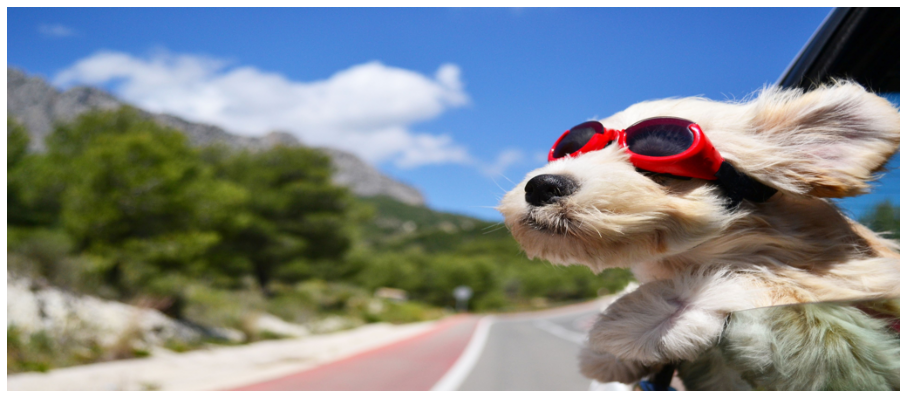

In [7]:
cool_dog = np.array(Image.open('data/cool_dog.jpg').resize((1024, 440))) / 255.0
show(cool_dog)

In [8]:
cool_dog_torch = torch.from_numpy(cool_dog).permute(2, 0, 1).unsqueeze(0).float()

grid = create_meshgrid(440, 1024, False)
grid += flow_up.permute(0, 2, 3, 1).cpu()

warped = kornia.geometry.transform.remap(cool_dog_torch, grid[..., 0], grid[..., 1])

/home/chris/anaconda3/envs/datamosh/lib/python3.6/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


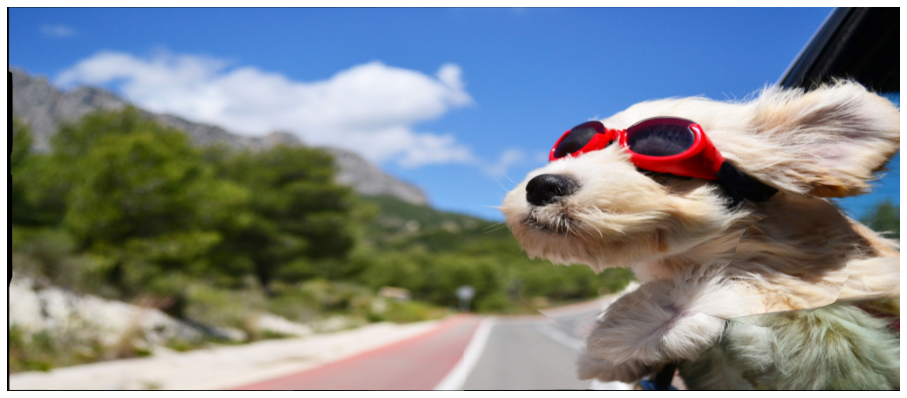

In [9]:
show(warped.squeeze(0).permute(1, 2, 0).numpy())

In [20]:

def read_frames(fname, h=720, w=1280):

    cap = cv2.VideoCapture(fname)

    frames = []

    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (w, h))

        frames.append(frame)

    cap.release()
    
    return frames

vid1 = read_frames('data/blinds.MOV')
vid2 = read_frames('data/test_video.MOV')

print(len(vid2))
print(len(vid2))

In [21]:
flows = []

for i, (image2, image1) in tqdm(enumerate(zip(vid2[:-1], vid2[1:])), total=len(vid2)):
    image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
    
    # image1 = cv2.resize(image1, (640, 360))
    # image2 = cv2.resize(image2, (640, 360))

    flow = cv2.calcOpticalFlowFarneback(image1, image2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    # flow = cv2.resize(flow, (w, h))
        
    flow = torch.from_numpy(np.array(flow)).permute(2, 0, 1).unsqueeze(0)
    
    flows.append(flow)


281it [00:48,  5.78it/s]                         


In [15]:
len(test_flows)

299

In [6]:
def convert_frame(f):
    f = np.array(f).astype(np.uint8)
    return torch.from_numpy(f).permute(2, 0, 1).float().unsqueeze(0)

np_frames = [np.array(f).astype(np.uint8) for f in frames]
frames = [convert_frame(f) for f in frames]

In [7]:
flows = []

with torch.no_grad():
    for i, (image2, image1) in enumerate(zip(frames[:-1], frames[1:])):
        image1 = image1.to(DEVICE)
        image2 = image2.to(DEVICE)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)

        flows.append(flow_up.cpu())
        
        if i == 500:
            break

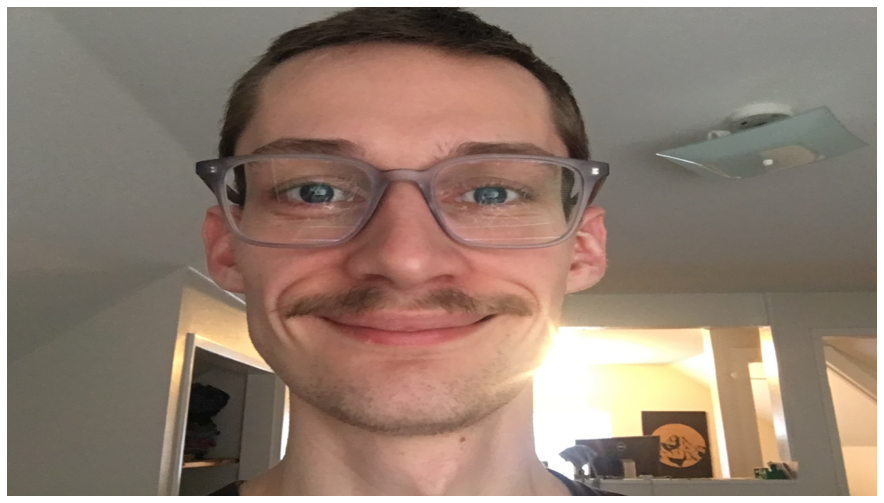

In [15]:
chris = np.array(Image.open('data/chris.JPG').resize((w, h)))
show(chris)

In [16]:

warped = torch.from_numpy(chris).permute(2, 0, 1).unsqueeze(0).float()
fg_mask = torch.ones_like(warped) * 255.

warps = []
masks = []

for flw in test_flows:

    grid = create_meshgrid(h, w, False)
    grid += flw.permute(0, 2, 3, 1).cpu() * 2

    warped = kornia.geometry.transform.remap(warped, grid[..., 0], grid[..., 1], mode='nearest', align_corners=True)
    fg_mask = kornia.geometry.transform.remap(fg_mask, grid[..., 0], grid[..., 1], mode='nearest', align_corners=True)

    masks.append(fg_mask.squeeze(0).permute(1, 2, 0).numpy())
    warps.append(warped.squeeze(0).permute(1, 2, 0).numpy())

In [17]:
outputs = []

for orig, warped, mask in zip(np_frames, warps, masks):
    mask = mask.astype(bool)
    warped[~mask] = orig[~mask]
    outputs.append(warped)
    

In [18]:
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (w, h))

outputs = vid1 + outputs

for frame in outputs:
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame.astype(np.uint8))

out.release()
